# NFL Big Data Bowl Clustering

## Import data

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

In [5]:
plays = pd.read_csv('/Users/elizabethgrace/Documents/coding/NFL_Data/plays.csv')
games = pd.read_csv('/Users/elizabethgrace/Documents/coding/NFL_Data/games.csv')
players = pd.read_csv('/Users/elizabethgrace/Documents/coding/NFL_Data/players.csv')
tracking2018 = pd.read_csv('/Users/elizabethgrace/Documents/coding/NFL_Data/tracking2018.csv')
tracking2019 = pd.read_csv('/Users/elizabethgrace/Documents/coding/NFL_Data/tracking2019.csv')
tracking2020 = pd.read_csv('/Users/elizabethgrace/Documents/coding/NFL_Data/tracking2020.csv')

## Preprocess Players Data

In [6]:
from Preprocessing_makers import preprocess_players

In [7]:
players_df = preprocess_players(players)

## Preprocess Tracking Data

In [8]:
from Preprocessing_makers import preprocess_tracking, preprocess_football_track

In [9]:
fg_tracking_2018, fg_tracking_2019, fg_tracking_2020 = preprocess_tracking(tracking2018, tracking2019, tracking2020, plays, 'Field Goal')

In [10]:
fg_tracking_ball = preprocess_football_track(fg_tracking_2018, fg_tracking_2019, fg_tracking_2020)

## Preprocess Play Data

In [11]:
from Preprocessing_makers import preprocess_play
from Cleaning_data import drop_by_index_difference

In [12]:
play_df = preprocess_play(plays)

In [13]:
play_df = drop_by_index_difference(play_df, fg_tracking_ball, 'field_goal_attempt')

## Make Field Goal DataFrame

In [14]:
from Preprocessing_makers import make_fieldGoal

In [15]:
field_goal_df = make_fieldGoal(play_df, players_df)

## Feature Engineering

In [16]:
from Feature_engineering import endzone_y_pos, expected_endzone_y_pos, kicker_core_dist, exp_err_y, off_center

### Fieldgoal Y-Position

In [17]:
field_goal_df = endzone_y_pos(field_goal_df, fg_tracking_ball)

### Fieldgoal Trajectory Position

In [18]:
attempts_df = field_goal_df[field_goal_df['specialTeamsResult'].isin(['Kick Attempt Good', 'Kick Attempt No Good'])]


In [19]:
attempts_ids = attempts_df[['gameId', 'playId']]

In [20]:
attempts_tracking = pd.merge(attempts_ids, fg_tracking_ball, left_on = ['gameId', 'playId'], right_on = ['gameId', 'playId'])


In [21]:
attempts_event = attempts_tracking[attempts_tracking['event']=='field_goal_attempt']

In [22]:
attempts_event['mergeId'] = attempts_event['gameId'].astype(str) + attempts_event['playId'].astype(str)
attempts_ids['mergeId'] = attempts_ids['gameId'].astype(str) + attempts_ids['playId'].astype(str)

/var/folders/q2/h9w_wgds16v57h69gp45grdw0000gn/T/ipykernel_68535/3006702610.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  attempts_event['mergeId'] = attempts_event['gameId'].astype(str) + attempts_event['playId'].astype(str)
/var/folders/q2/h9w_wgds16v57h69gp45grdw0000gn/T/ipykernel_68535/3006702610.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  attempts_ids['mergeId'] = attempts_ids['gameId'].astype(str) + attempts_ids['playId'].astype(str)


In [23]:
indices_to_drop = attempts_ids[~attempts_ids['mergeId'].isin(attempts_event['mergeId'])].index

In [ ]:
#fg_tracking_ball[(fg_tracking_ball['gameId']==2018122302) & (fg_tracking_ball['playId']==1858)]

In [ ]:
#fg_tracking_ball = fg_tracking_ball.drop(indices_to_drop)

In [24]:
attempts_df = attempts_df.drop(indices_to_drop)

In [25]:
attempts_df = expected_endzone_y_pos(attempts_df, fg_tracking_ball, 'field_goal_attempt')

/Users/elizabethgrace/Documents/coding/NFL-BDB-2022/Feature_engineering.py:189: RuntimeWarning: invalid value encountered in double_scalars
  m = (y2-y1)/(x2-x1)


### Kicker Core Distance

While performing this compute, I discovered that it is apparently possible for a kicker not to be present for a play (???????????).

For an example of where this occurs, check out `gameId = 2019091502` and `playId = 2075` in the 2019 tracking data.

In [26]:
attempts_df = kicker_core_dist(attempts_df, fg_tracking_2018, fg_tracking_2019, fg_tracking_2020, fg_tracking_ball, 'field_goal_attempt', k=3)


/Users/elizabethgrace/Documents/coding/NFL-BDB-2022/Feature_engineering.py:335: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  opposing_team_players['kicker_dist'] = l2_norm(kicker_x, kicker_y, opposing_team_players['x'], opposing_team_players['y'])


## Final Preprocessing Steps

In [27]:
from Preprocessing_makers import preprocess_fg

In [128]:
from sklearn.preprocessing import StandardScaler, LabelEncoder

In [124]:
def preprocess_fg2(fg_plays):
    '''
    This function the FieldGoal dataframe for clustering.

    Parameters:
    -----------
    fg_plays - FieldGoal dataframe
    ...

    Returns:
    -----------
    fg_scale - processed FieldGoal dataframe

    '''
    #reduce number of columns to those with numeric values or one-hot-encode categoricals
    useful_cols = ['specialTeamsResult', 'yardlineNumber', 
               'gameClockSeconds', 'penaltyCodes', 
               'penaltyYards', 'preSnapHomeScore', 
               'preSnapVisitorScore', 'kicker_height', 
               'kicker_weight', 'down',
              'yardsToGo', 'kickLength',
              'playResult', 'endzone_y', 'kicker_core_dist', 
            'kicker_core_dist_1','endzone_y_error','endzone_y_off_center']
    
    #useful_cols with blockers
    #useful_cols = ['specialTeamsResult', 'yardlineNumber', 
   #            'gameClockSeconds', 'penaltyCodes', 
   #            'penaltyYards', 'preSnapHomeScore', 
   #            'preSnapVisitorScore', 'kicker_height', 
   #            'kicker_weight', 'blocker_height', 
    #           'blocker_weight', 'down',
    #          'yardsToGo', 'kickLength',
    #          'playResult', 'expected_endzone_y', 
    #             'endzone_y', 'kicker_core_dist']
    fg_df = fg_plays[useful_cols].dropna()
    #one-hot-encode SpecialTeamsResult and penaltyCodes
    le_str = LabelEncoder()
    le_pc = LabelEncoder()
    ohe_str = le_str.fit_transform(fg_df['specialTeamsResult'])
    ohe_pc = le_pc.fit_transform(fg_df['penaltyCodes'])
    new_fgs = fg_df.drop(['specialTeamsResult', 'penaltyCodes'], axis=1)
    #new_fgs['specialTeamsResult'] = ohe_str
    #new_fgs['penaltyCodes'] = ohe_pc
    
    #scale data, but only non-categorical columns
    scale = StandardScaler()
    fg_scale = scale.fit_transform(new_fgs)
    #TO-DO QUESTION: do we want to scale categoricals too? No
    
    #make this back into a data frame
    fg_scale = pd.DataFrame(fg_scale, columns = new_fgs.columns)
    
    #add categorical columns back
    fg_scale['specialTeamsResult'] = ohe_str
    fg_scale['penaltyCodes'] = ohe_pc
    #we are running a distance dependent algorithm
    return fg_scale, fg_df

In [ ]:
X, final_df = preprocess_fg(attempts_df)

In [ ]:
X.isnull().sum()

## Clustering

In [28]:
import hdbscan

import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
model = hdbscan.HDBSCAN()

In [ ]:
model_results = model.fit(X)

In [ ]:
model_results.labels_.max()

In [ ]:
final_df['cluster_id'] = model_results.labels_

In [ ]:
final_df['cluster_id'].value_counts()

In [ ]:
plt.figure(figsize = (16,18))
model.condensed_tree_.plot(select_clusters=True, selection_palette=sns.color_palette())
plt.show()

In [ ]:
cluster0 = final_df[final_df['cluster_id']==0]
cluster1 = final_df[final_df['cluster_id']==1]
cluster2 = final_df[final_df['cluster_id']==2]
cluster3 = final_df[final_df['cluster_id']==3]
cluster4 = final_df[final_df['cluster_id']==4]
cluster5 = final_df[final_df['cluster_id']==5]

outliers = final_df[final_df['cluster_id']==-1]

In [ ]:
cluster0['specialTeamsResult'].value_counts()

In [ ]:
cluster1['specialTeamsResult'].value_counts()

In [ ]:
cluster2['specialTeamsResult'].value_counts()

In [ ]:
cluster3['specialTeamsResult'].value_counts()

In [ ]:
cluster4['specialTeamsResult'].value_counts()

In [ ]:
cluster5['specialTeamsResult'].value_counts()

In [ ]:
outliers['specialTeamsResult'].value_counts()

In [ ]:
cluster0[['expected_endzone_y', 'endzone_y', 'kicker_core_dist']].describe()
#Good

In [ ]:
cluster1[['expected_endzone_y', 'endzone_y', 'kicker_core_dist']].describe()
#No Good

In [ ]:
cluster2[['expected_endzone_y', 'endzone_y', 'kicker_core_dist']].describe()
#No Good

In [ ]:
cluster3[['expected_endzone_y', 'endzone_y', 'kicker_core_dist']].describe()
#No Good

In [ ]:
cluster5[['expected_endzone_y', 'endzone_y', 'kicker_core_dist']].describe()
#Good

The average values for `expected_endzone_y` and `endzone_y` differ more for the `Kick_attempt_No_good` and are tight on `kick_attempt_good` so we will add a column with their difference. 

Additionally, we want a column for distance off-center to account for symmetry, and should be a nice cluster feature.

Let's add in the new columns and see how it looks.

In [72]:
df2 = attempts_df.copy()

In [73]:
attempts_df2 = exp_err_y(df2)
attempts_df3 = off_center(attempts_df2)

In [31]:
X2, final_df2 = preprocess_fg(attempts_df3)

In [32]:
model2 = hdbscan.HDBSCAN()

In [33]:
model2_results=model2.fit(X2)

In [34]:
model2_results.labels_.max()

4

In [35]:
final_df2['cluster_id']=model2_results.labels_

In [36]:
final_df2['cluster_id'].value_counts()

 4    1856
-1     273
 2     135
 3      69
 0      17
 1      16
Name: cluster_id, dtype: int64

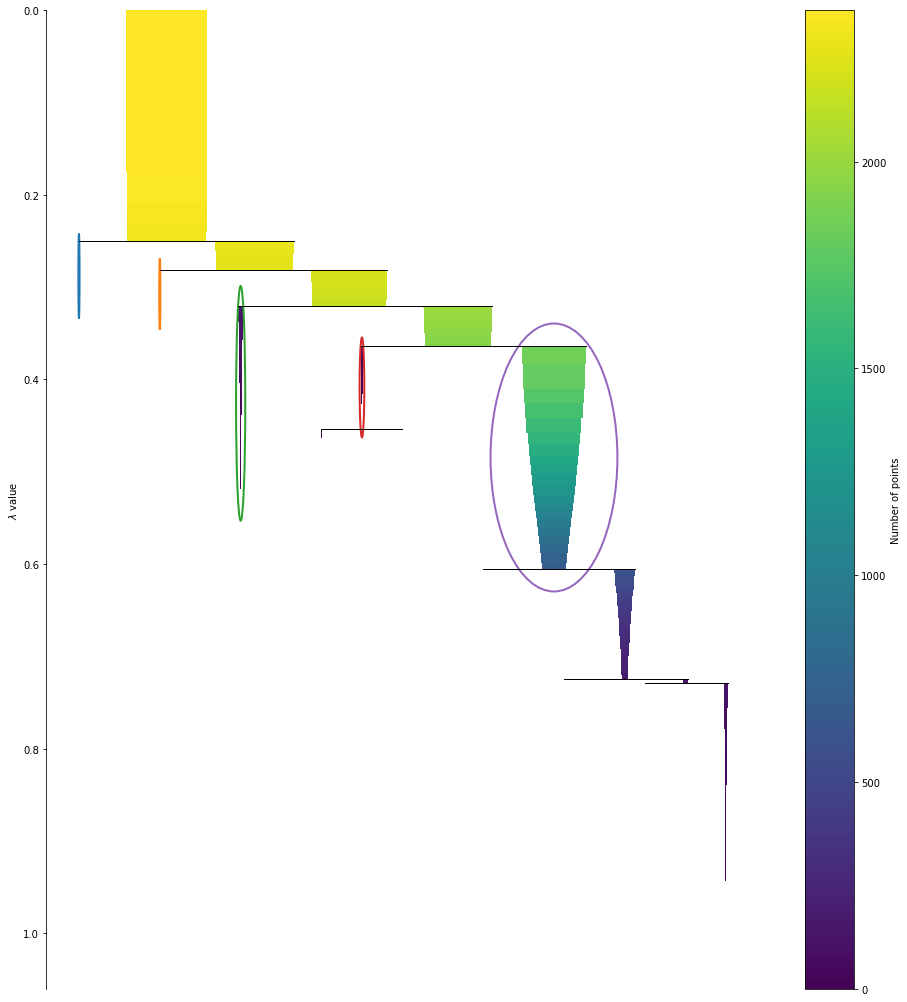

In [37]:
plt.figure(figsize = (16,18))
model2.condensed_tree_.plot(select_clusters=True, selection_palette=sns.color_palette())
plt.show()

In [38]:
Scluster0 = final_df2[final_df2['cluster_id']==0]
Scluster1 = final_df2[final_df2['cluster_id']==1]
Scluster2 = final_df2[final_df2['cluster_id']==2]
Scluster3 = final_df2[final_df2['cluster_id']==3]
Scluster4 = final_df2[final_df2['cluster_id']==4]

Soutliers = final_df2[final_df2['cluster_id']==-1]

In [39]:
Scluster0['specialTeamsResult'].value_counts()

Kick Attempt Good    17
Name: specialTeamsResult, dtype: int64

In [40]:
Scluster1['specialTeamsResult'].value_counts()

Kick Attempt No Good    16
Name: specialTeamsResult, dtype: int64

In [41]:
Scluster2['specialTeamsResult'].value_counts()

Kick Attempt No Good    135
Name: specialTeamsResult, dtype: int64

In [42]:
Scluster3['specialTeamsResult'].value_counts()

Kick Attempt No Good    69
Name: specialTeamsResult, dtype: int64

In [43]:
Scluster4['specialTeamsResult'].value_counts()

Kick Attempt Good    1856
Name: specialTeamsResult, dtype: int64

In [44]:
Soutliers['specialTeamsResult'].value_counts()

Kick Attempt Good       147
Kick Attempt No Good    126
Name: specialTeamsResult, dtype: int64

In [45]:
Scluster2[['endzone_y_error', 'endzone_y', 'kicker_core_dist', 'endzone_y_off_center']].describe()
#no good

,endzone_y_error,endzone_y,kicker_core_dist,endzone_y_off_center
count,135.000000,135.000000,135.000000,135.000000
mean,1.986149,22.565111,6.429977,4.101556
std,1.666590,0.941620,0.550742,0.941620
min,0.022000,19.888333,4.859815,1.301667
25%,0.751520,21.948333,6.088308,3.464167
50%,1.553684,22.708333,6.376410,3.958333
75%,2.784196,23.202500,6.859066,4.718333
max,8.786915,25.365000,7.567463,6.778333


In [46]:
Scluster4[['endzone_y_error', 'endzone_y', 'kicker_core_dist', 'endzone_y_off_center']].describe()
#good

,endzone_y_error,endzone_y,kicker_core_dist,endzone_y_off_center
count,1856.000000,1856.000000,1856.000000,1856.000000
mean,0.983997,26.649760,6.495958,1.120899
std,0.983381,1.368116,0.587742,0.784179
min,0.000186,23.000000,3.986389,0.003333
25%,0.271727,25.672500,6.104584,0.480833
50%,0.660727,26.651667,6.535736,0.983333
75%,1.384662,27.636250,6.894048,1.634167
max,6.638309,30.495000,8.255374,3.828333


In [47]:
Soutliers[['endzone_y_error', 'endzone_y', 'kicker_core_dist', 'endzone_y_off_center']].describe()


,endzone_y_error,endzone_y,kicker_core_dist,endzone_y_off_center
count,273.000000,273.000000,273.000000,273.000000
mean,3.016073,26.746703,6.415358,2.982283
std,2.796489,3.801920,0.997087,2.352512
min,0.002432,16.860000,3.295285,0.006667
25%,0.746928,24.390000,5.914474,1.116667
50%,2.266832,26.415000,6.419354,2.346667
75%,4.504826,29.228333,6.920723,4.163333
max,14.745833,38.420000,11.284224,11.753333


In [48]:
attempts_df3['endzone_y_error'].idxmax()

64

In [49]:
def get_play(game_id, play_id, tracking):
    '''
    This function creates the tracking dataframes.

    Parameters:
    -----------
    game_id, play_id - game and play of interest
    tracking - tracking dataframe the that game and play are in
    ...

    Returns:
    -----------
    play - dataframe of just the tracking data for the particular play of interest
    '''
    game = tracking[tracking['gameId'] == game_id]
    play_ex = game[game['playId'] == play_id]
    
    return play_ex

In [50]:
attempts_df3.loc[64]['gameId']

2018091608

In [51]:
print("expected y:",attempts_df3.loc[64]['expected_endzone_y'])
print("actual y:", attempts_df3.loc[64]['endzone_y'])

expected y: 43.34583333333326
actual y: 28.6


In [52]:
playMax = get_play(attempts_df3.loc[64]['gameId'],attempts_df3.loc[64]['playId'], fg_tracking_2018)

In [53]:
playMax_ball= get_play(attempts_df3.loc[64]['gameId'],attempts_df3.loc[64]['playId'], fg_tracking_ball)
playMax_ball.head(60)

,gameId,playId,time,x,y,s,a,dis,event,displayName,team,frameId,playDirection
4299,2018091608,3144,2018-09-16T19:18:05.700,79.06,24.00,0.00,0.00,0.00,None,football,football,1,right
4300,2018091608,3144,2018-09-16T19:18:05.800,79.06,24.00,0.00,0.00,0.00,None,football,football,2,right
4301,2018091608,3144,2018-09-16T19:18:05.900,79.06,24.00,0.00,0.00,0.00,None,football,football,3,right
4302,2018091608,3144,2018-09-16T19:18:06.000,79.06,24.00,0.00,0.00,0.00,None,football,football,4,right
4303,2018091608,3144,2018-09-16T19:18:06.100,79.06,24.00,0.00,0.00,0.00,None,football,football,5,right
4304,2018091608,3144,2018-09-16T19:18:06.200,79.06,24.00,0.00,0.00,0.00,None,football,football,6,right
4305,2018091608,3144,2018-09-16T19:18:06.300,79.06,24.00,0.00,0.00,0.00,None,football,football,7,right
4306,2018091608,3144,2018-09-16T19:18:06.400,79.06,24.00,0.00,0.00,0.00,None,football,football,8,right
4307,2018091608,3144,2018-09-16T19:18:06.500,79.06,24.00,0.00,0.01,0.00,None,football,football,9,right
4308,2018091608,3144,2018-09-16T19:18:06.600,79.06,24.00,0.00,0.01,0.00,None,football,football,10,right


In [54]:
from play_animation import animate_play

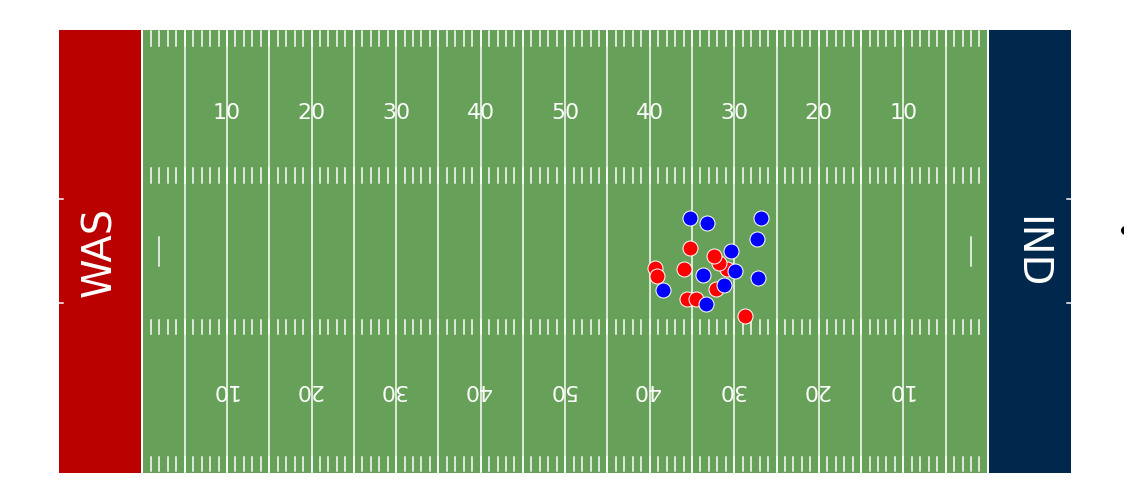

In [55]:
animate_play(2018091608, attempts_df3.loc[64]['playId'], fg_tracking_2018, games=games, save_to='fgMaxError.mp4')

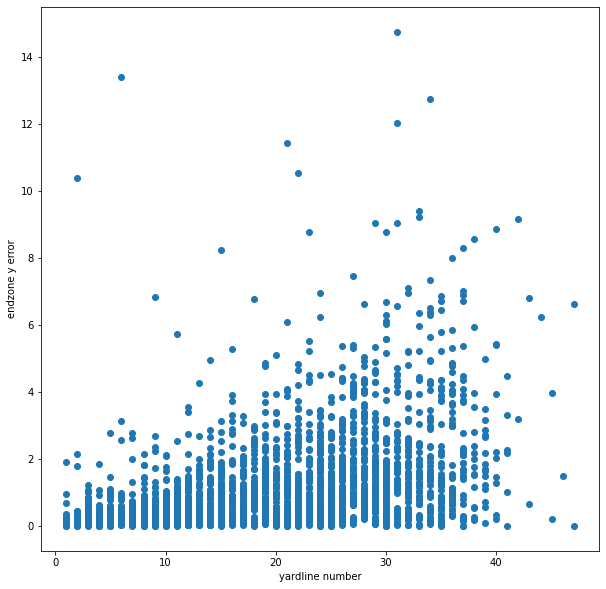

In [56]:
plt.figure(figsize = (10,10))

plt.scatter(attempts_df3['yardlineNumber'], attempts_df3['endzone_y_error'])
plt.xlabel("yardline number")
plt.ylabel("endzone y error")

plt.show()

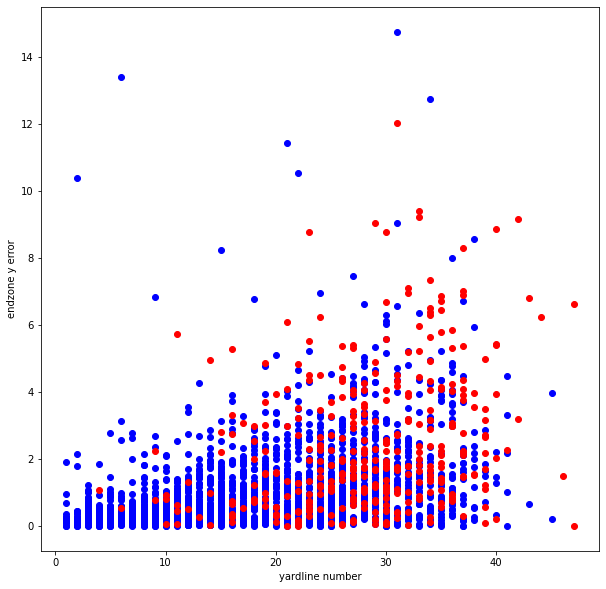

In [62]:
plt.figure(figsize = (10,10))

plt.scatter(attempts_df3[attempts_df3['specialTeamsResult']=='Kick Attempt Good']['yardlineNumber'], attempts_df3[attempts_df3['specialTeamsResult']=='Kick Attempt Good']['endzone_y_error'], color = 'b')
plt.scatter(attempts_df3[attempts_df3['specialTeamsResult']=='Kick Attempt No Good']['yardlineNumber'], attempts_df3[attempts_df3['specialTeamsResult']=='Kick Attempt No Good']['endzone_y_error'], color = 'r')
plt.xlabel("yardline number")
plt.ylabel("endzone y error")

plt.show()

In [63]:
np.min(attempts_df['yardlineNumber'])

1

In [ ]:
fix, axes =plt.subplots()

axes.bar(attempts_df3['yardlineNumber'].to_list(), attempts_df3[attempts_df3['SpecialTeamsResult']=='Kick Good']['endzone_y_error'], label)
axes.bar(attempts_df3['yardlineNumber'].to_list, attempts_df3['endzone_y_error'])
plt.xlabel("yardline number")
plt.ylabel("endzone y error")

plt.show()

In [81]:
#test:
def get_event(game_id, play_id, track_fp, event):
    '''
    This function creates a small dataframe for football tracking around the event.

    Parameters:
    -----------
    game_id, play_id - game and play of interest
    track_fp - football-specific tracking dataframe for play type
    event - string of the event that we want to find, i.e., 'extra_point_attempt'
    ...

    Returns:
    -----------
    event_df - 11-row dataframe of tracking data around the event
    event_index - the index of the moment of the kick based on max velocity
    #frame_id - frameId of event
    '''
    play_ex = get_play(game_id, play_id, track_fp)
    
    index = play_ex.index[play_ex['event']== event].values[0]
    event_df = play_ex.loc[index-5:index+5,:]
    event_index = event_df['s'].idxmax()
    
    if (event_index == event_df.index[-1]) or (event_index == event_df.index[-2]):
        event_df = play_ex.loc[index-10:index+10,:]
        
    #frame_id = play_ex.loc[event_index]['frameId']
    
    return event_df, event_index

def find_kickline3(game_id, play_id, track_fp, event):
    
    '''
    This function gives a straightline expectation of where the football crosses the endzone.

    Parameters:
    -----------
    game_id, play_id - game and play of interest
    track_fp - football-specific tracking dataframe for play type
    event - string of the event that we want to find, i.e., 'extra_point_attempt'
    ...
    finds event_index from frame_id of play and uses the x & y values from event_index
    and event_index+1 to calculate a straight line trajectory of the football

    Returns:
    -----------
    y value expectation of football at x=120
    '''
    event_df, event_index = get_event(game_id, play_id, track_fp, event)
    #event_index = event_df.index[event_df['frameId']==frame_id].values[0]
    
    #adjust for sensitivity of the tracking data by pulling further samples
    
    x1 = event_df['x'][event_index]
    y1 = event_df['y'][event_index]
    x2 = event_df['x'][event_index+2]
    y2 = event_df['y'][event_index+2]
    
    m = (y2-y1)/(x2-x1)
    
    return m*(120-x1)+y1


In [75]:
attempts_df4 = attempts_df3.copy()
attempts_df4['expected_endzone_y2'] = attempts_df3.index.map(
        lambda x: find_kickline2(
            attempts_df3.loc[x]['gameId'],
            attempts_df3.loc[x]['playId'],
            fg_tracking_ball, "field_goal_attempt"))

/var/folders/q2/h9w_wgds16v57h69gp45grdw0000gn/T/ipykernel_68535/464991723.py:60: RuntimeWarning: invalid value encountered in double_scalars
  m = (y2-y1)/(x2-x1)


In [76]:
attempts_df4['exp_y_err2']=np.abs(attempts_df4['expected_endzone_y2']-attempts_df4['endzone_y'])

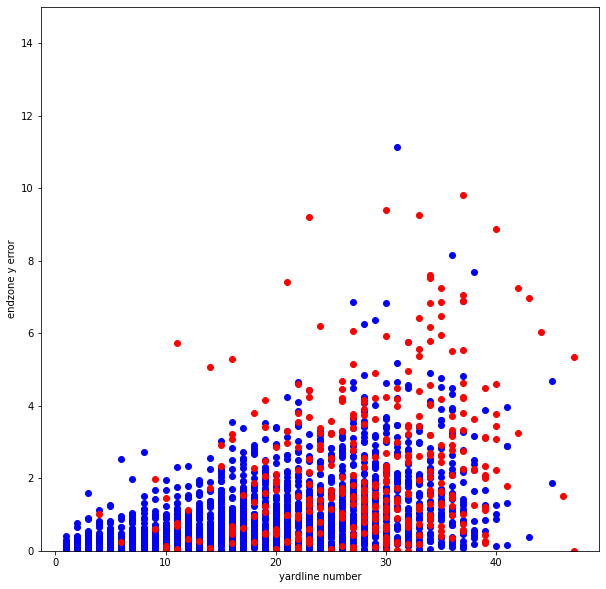

In [80]:
plt.figure(figsize = (10,10))

plt.scatter(attempts_df4[attempts_df4['specialTeamsResult']=='Kick Attempt Good']['yardlineNumber'], attempts_df4[attempts_df4['specialTeamsResult']=='Kick Attempt Good']['exp_y_err2'], color = 'b')
plt.scatter(attempts_df4[attempts_df4['specialTeamsResult']=='Kick Attempt No Good']['yardlineNumber'], attempts_df4[attempts_df4['specialTeamsResult']=='Kick Attempt No Good']['exp_y_err2'], color = 'r')
plt.xlabel("yardline number")
plt.ylabel("endzone y error")
plt.ylim((0,15))

plt.show()

In [101]:
attempts_df5 = attempts_df3.copy()
attempts_df5['expected_endzone_y2'] = attempts_df5.index.map(
        lambda x: find_kickline3(
            attempts_df5.loc[x]['gameId'],
            attempts_df5.loc[x]['playId'],
            fg_tracking_ball, "field_goal_attempt"))

In [102]:
attempts_df5['endzone_y_error']=np.abs(attempts_df5['expected_endzone_y2']-attempts_df5['endzone_y'])

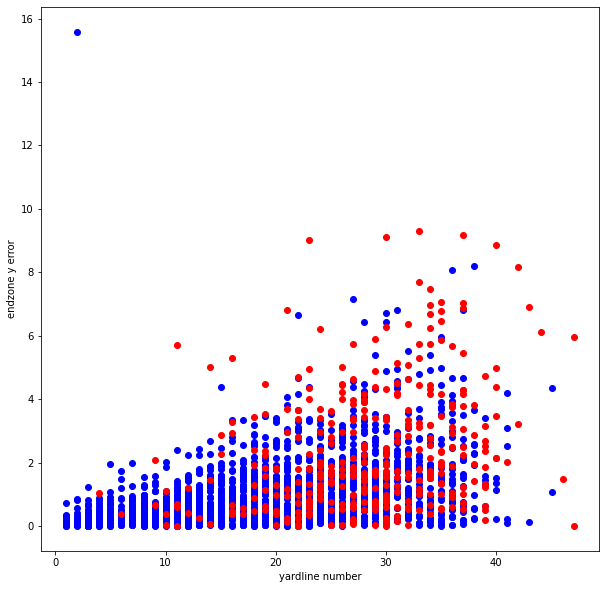

In [97]:
plt.figure(figsize = (10,10))

plt.scatter(attempts_df5[attempts_df5['specialTeamsResult']=='Kick Attempt Good']['yardlineNumber'], attempts_df5[attempts_df5['specialTeamsResult']=='Kick Attempt Good']['exp_y_err2'], color = 'b')
plt.scatter(attempts_df5[attempts_df5['specialTeamsResult']=='Kick Attempt No Good']['yardlineNumber'], attempts_df5[attempts_df5['specialTeamsResult']=='Kick Attempt No Good']['exp_y_err2'], color = 'r')
plt.xlabel("yardline number")
plt.ylabel("endzone y error")
#plt.ylim((0,15))

plt.show()

In [94]:
err_outliers = attempts_df5[attempts_df5['exp_y_err2']>=8][['gameId','playId']]
err_outliers

,gameId,playId
156,2018093006,542
224,2018100704,2912
293,2018101408,3083
459,2018111106,1030
918,2019092213,1552
1891,2020101900,2951
1954,2020110102,273
2006,2020110804,2726
2307,2020122013,2264


In [98]:
play542=get_play(2018093006,542, fg_tracking_ball)
play542

,gameId,playId,time,x,y,s,a,dis,event,displayName,team,frameId,playDirection
10203,2018093006,542,2018-09-30T17:19:25.000,107.99,23.973333,0.00,0.00,0.00,None,football,football,1,left
10204,2018093006,542,2018-09-30T17:19:25.100,107.99,23.973333,0.00,0.00,0.00,None,football,football,2,left
10205,2018093006,542,2018-09-30T17:19:25.200,107.99,23.973333,0.00,0.00,0.00,None,football,football,3,left
10206,2018093006,542,2018-09-30T17:19:25.300,107.99,23.973333,0.00,0.00,0.00,None,football,football,4,left
10207,2018093006,542,2018-09-30T17:19:25.400,107.99,23.973333,0.00,0.00,0.00,None,football,football,5,left
10208,2018093006,542,2018-09-30T17:19:25.500,107.99,23.973333,0.00,0.00,0.00,None,football,football,6,left
10209,2018093006,542,2018-09-30T17:19:25.600,107.99,23.973333,0.00,0.00,0.00,None,football,football,7,left
10210,2018093006,542,2018-09-30T17:19:25.700,107.99,23.973333,0.00,0.00,0.00,None,football,football,8,left
10211,2018093006,542,2018-09-30T17:19:25.800,107.99,23.973333,0.00,0.00,0.00,None,football,football,9,left
10212,2018093006,542,2018-09-30T17:19:25.900,107.99,23.973333,0.00,0.00,0.00,None,football,football,10,left


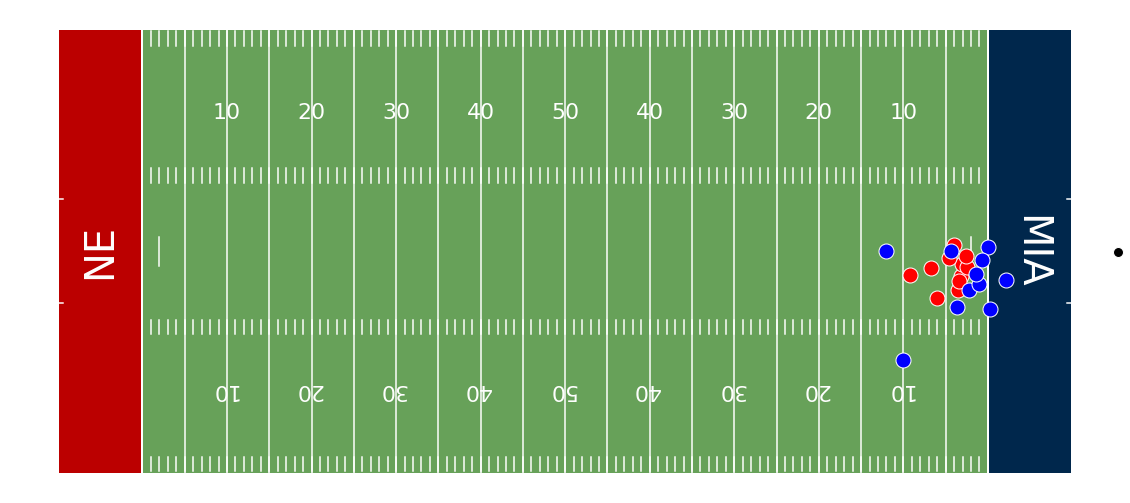

In [96]:
animate_play(2018093006, 542, fg_tracking_2018, games=games, save_to='fgPlay542.mp4')

In [99]:
play2912=get_play(2018100704,2912, fg_tracking_ball)
play2912

,gameId,playId,time,x,y,s,a,dis,event,displayName,team,frameId,playDirection
14362,2018100704,2912,2018-10-07T19:10:39.200,72.91,29.15,0.79,0.78,0.10,None,football,football,1,right
14363,2018100704,2912,2018-10-07T19:10:39.300,72.93,29.27,0.90,0.47,0.12,None,football,football,2,right
14364,2018100704,2912,2018-10-07T19:10:39.400,72.94,29.38,0.96,0.17,0.11,None,football,football,3,right
14365,2018100704,2912,2018-10-07T19:10:39.500,72.96,29.50,1.00,0.06,0.12,None,football,football,4,right
14366,2018100704,2912,2018-10-07T19:10:39.600,72.97,29.59,0.98,0.24,0.10,None,football,football,5,right
14367,2018100704,2912,2018-10-07T19:10:39.700,72.98,29.68,0.95,0.36,0.09,None,football,football,6,right
14368,2018100704,2912,2018-10-07T19:10:39.800,73.00,29.76,0.91,0.45,0.08,None,football,football,7,right
14369,2018100704,2912,2018-10-07T19:10:39.900,73.01,29.84,0.86,0.50,0.08,None,football,football,8,right
14370,2018100704,2912,2018-10-07T19:10:40.000,73.02,29.91,0.81,0.54,0.07,None,football,football,9,right
14371,2018100704,2912,2018-10-07T19:10:40.100,73.02,29.95,0.77,0.54,0.04,None,football,football,10,right


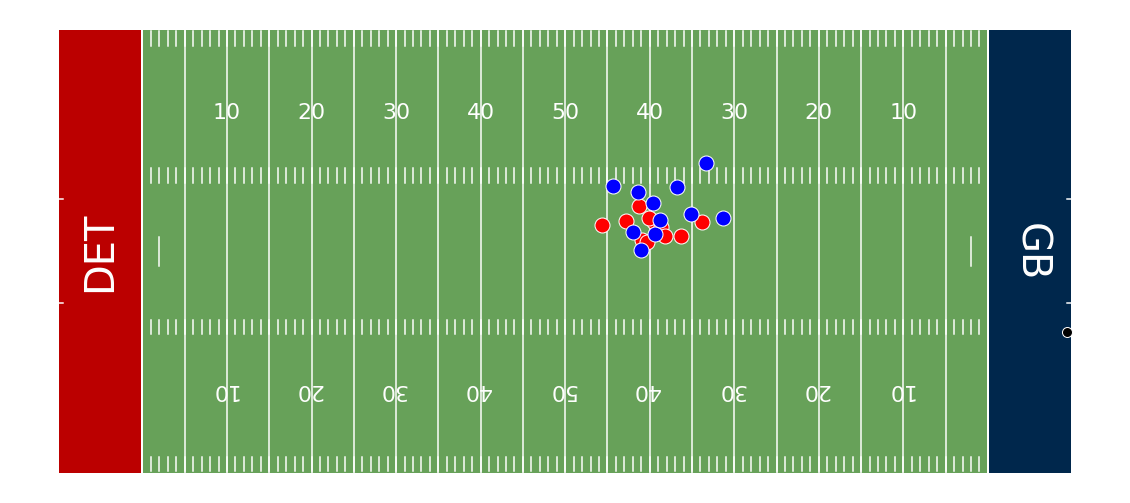

In [100]:
animate_play(2018100704,2912, fg_tracking_2018, games=games, save_to='fgPlay2912.mp4')

Now we're going to cluster with the adjusted kickline estimate function.

In [103]:
X3, final_df3 = preprocess_fg(attempts_df5)

In [104]:
model3 = hdbscan.HDBSCAN()

In [105]:
model3_results = model3.fit(X3)

In [106]:
model3_results.labels_.max()

4

In [107]:
final_df3['cluster_id']=model3_results.labels_

In [108]:
final_df3['cluster_id'].value_counts()

 4    1858
-1     306
 2     106
 3      68
 0      17
 1      16
Name: cluster_id, dtype: int64

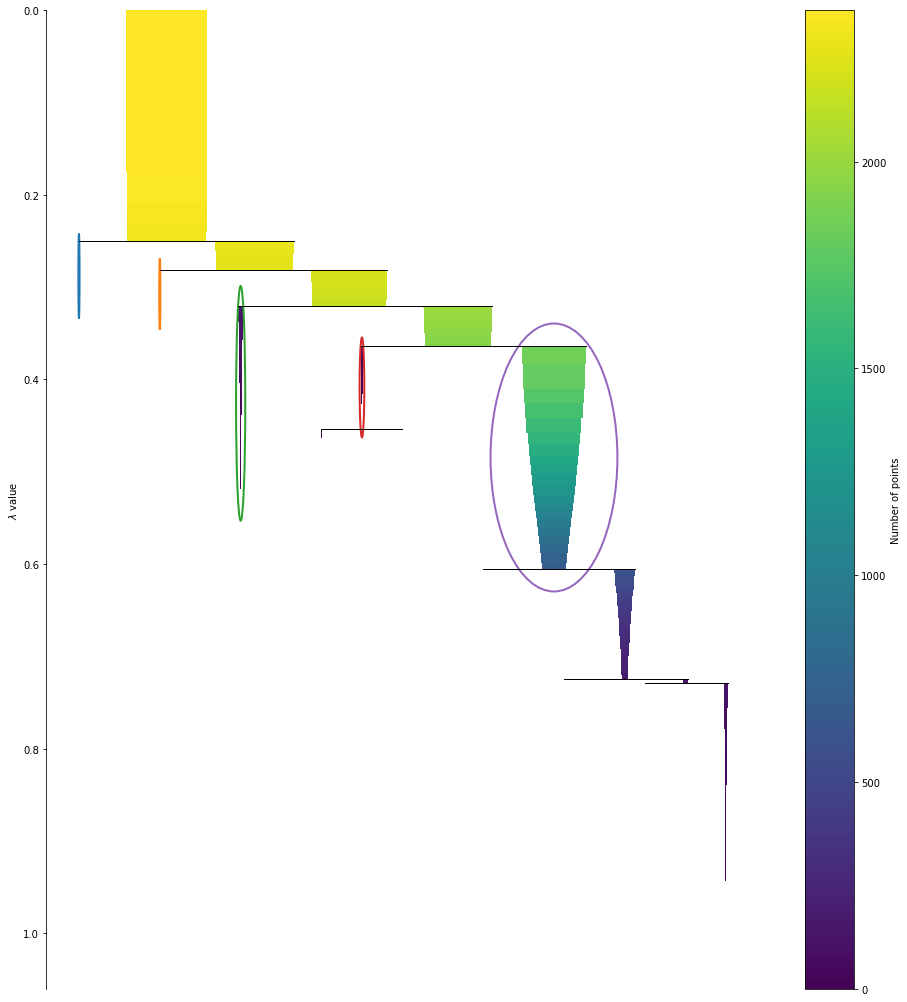

In [109]:
plt.figure(figsize = (16,18))
model2.condensed_tree_.plot(select_clusters=True, selection_palette=sns.color_palette())
plt.show()

In [110]:
cluster3_0 = final_df3[final_df3['cluster_id']==0]
cluster3_1 = final_df3[final_df3['cluster_id']==1]
cluster3_2 = final_df3[final_df3['cluster_id']==2]
cluster3_3 = final_df3[final_df3['cluster_id']==3]
cluster3_4 = final_df3[final_df3['cluster_id']==4]

outliers3 = final_df3[final_df3['cluster_id']==-1]

In [111]:
cluster3_0['specialTeamsResult'].value_counts()

Kick Attempt Good    17
Name: specialTeamsResult, dtype: int64

In [112]:
cluster3_1['specialTeamsResult'].value_counts()

Kick Attempt No Good    16
Name: specialTeamsResult, dtype: int64

In [113]:
cluster3_2['specialTeamsResult'].value_counts()

Kick Attempt No Good    106
Name: specialTeamsResult, dtype: int64

In [114]:
cluster3_3['specialTeamsResult'].value_counts()

Kick Attempt No Good    68
Name: specialTeamsResult, dtype: int64

In [115]:
cluster3_4['specialTeamsResult'].value_counts()

Kick Attempt Good    1858
Name: specialTeamsResult, dtype: int64

In [116]:
outliers3['specialTeamsResult'].value_counts()

Kick Attempt No Good    156
Kick Attempt Good       150
Name: specialTeamsResult, dtype: int64

In [117]:
cluster3_4[['endzone_y_error', 'endzone_y', 'kicker_core_dist', 'endzone_y_off_center']].describe()
#good

,endzone_y_error,endzone_y,kicker_core_dist,endzone_y_off_center
count,1858.000000,1858.000000,1858.000000,1858.000000
mean,0.892491,26.659299,6.495024,1.116403
std,0.874682,1.363987,0.588368,0.783255
min,0.001571,23.000000,3.986389,0.003333
25%,0.242878,25.686250,6.103265,0.476667
50%,0.615760,26.663333,6.534795,0.981667
75%,1.258705,27.648750,6.892810,1.631667
max,5.405692,30.495000,8.431097,3.828333


In [118]:
cluster3_2[['endzone_y_error', 'endzone_y', 'kicker_core_dist', 'endzone_y_off_center']].describe()
#no good

,endzone_y_error,endzone_y,kicker_core_dist,endzone_y_off_center
count,106.000000,106.000000,106.000000,106.000000
mean,1.866604,22.670770,6.470433,3.995896
std,1.509091,0.761093,0.509668,0.761093
min,0.001512,20.423333,5.370084,2.141667
25%,0.676933,22.176250,6.113659,3.450417
50%,1.594933,22.813333,6.381968,3.853333
75%,2.485784,23.216250,6.881443,4.490417
max,6.980511,24.525000,7.567463,6.243333


In [119]:
outliers3[['endzone_y_error', 'endzone_y', 'kicker_core_dist', 'endzone_y_off_center']].describe()
#

,endzone_y_error,endzone_y,kicker_core_dist,endzone_y_off_center
count,306.000000,306.000000,306.000000,306.000000
mean,2.551214,26.273971,6.394123,3.131302
std,2.339790,3.865622,0.970298,2.293589
min,0.003662,16.860000,3.295285,0.006667
25%,0.685525,23.772500,5.933099,1.259583
50%,1.825150,25.840833,6.404186,2.710000
75%,3.948611,28.817083,6.893370,4.611667
max,15.580000,38.420000,11.284224,11.753333


In [121]:
from Feature_engineering import compute_kicker_core_dist

In [122]:
def kicker_core_dist(pt_play, track_pt18, track_pt19, track_pt20, track_fp, event, k=5):
    
    tracking = pd.concat([track_pt18, track_pt19, track_pt20])

    pt_play[f'kicker_core_dist_{k}'] = pt_play.index.map(
        lambda x: compute_kicker_core_dist(
            pt_play.loc[x]['gameId'],
            pt_play.loc[x]['playId'],
            tracking,
            track_fp,
            event,
            k=k
        )
    )

    return pt_play

In [123]:
attempts_df5 = kicker_core_dist(attempts_df5, fg_tracking_2018, fg_tracking_2019, fg_tracking_2020, fg_tracking_ball, 'field_goal_attempt', k=1)


/Users/elizabethgrace/Documents/coding/NFL-BDB-2022/Feature_engineering.py:335: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  opposing_team_players['kicker_dist'] = l2_norm(kicker_x, kicker_y, opposing_team_players['x'], opposing_team_players['y'])


In [129]:
X4, final_df4 = preprocess_fg2(attempts_df5)

In [130]:
model4 = hdbscan.HDBSCAN()

In [131]:
model4_results = model4.fit(X4)

In [132]:
model4_results.labels_.max()

4

In [133]:
final_df4['cluster_id']=model4_results.labels_
final_df4['cluster_id'].value_counts()

 4    1836
-1     336
 2     112
 3      62
 0      14
 1      11
Name: cluster_id, dtype: int64

In [135]:
cluster4_0 = final_df4[final_df4['cluster_id']==0]
cluster4_1 = final_df4[final_df4['cluster_id']==1]
cluster4_2 = final_df4[final_df4['cluster_id']==2]
cluster4_3 = final_df4[final_df4['cluster_id']==3]
cluster4_4 = final_df4[final_df4['cluster_id']==4]

outliers4 = final_df4[final_df4['cluster_id']==-1]

In [136]:
print("Cluster 0:",cluster4_0['specialTeamsResult'].value_counts())
print("Cluster 1:",cluster4_1['specialTeamsResult'].value_counts())
print("Cluster 2:",cluster4_2['specialTeamsResult'].value_counts())
print("Cluster 3:",cluster4_3['specialTeamsResult'].value_counts())
print("Cluster 4:",cluster4_4['specialTeamsResult'].value_counts())
print("Outliers:",outliers4['specialTeamsResult'].value_counts())

Cluster 0: Kick Attempt Good    14
Name: specialTeamsResult, dtype: int64
Cluster 1: Kick Attempt No Good    11
Name: specialTeamsResult, dtype: int64
Cluster 2: Kick Attempt No Good    112
Name: specialTeamsResult, dtype: int64
Cluster 3: Kick Attempt No Good    62
Name: specialTeamsResult, dtype: int64
Cluster 4: Kick Attempt Good    1836
Name: specialTeamsResult, dtype: int64
Outliers: Kick Attempt Good       175
Kick Attempt No Good    161
Name: specialTeamsResult, dtype: int64


In [153]:
print("Cluster 0:",cluster5_0['penaltyCodes'].value_counts())
print()
print("Cluster 1:",cluster5_1['penaltyCodes'].value_counts())
print()
print("Cluster 2:",cluster5_2['penaltyCodes'].value_counts())
print()
print("Cluster 3:",cluster5_3['penaltyCodes'].value_counts())
print()
print("Cluster 4:",cluster5_4['penaltyCodes'].value_counts())
print()
print("Outliers:",outliers5['penaltyCodes'].value_counts())

Cluster 0: DOF    12
ILF     2
Name: penaltyCodes, dtype: int64

Cluster 1: no penalty    9
Name: penaltyCodes, dtype: int64

Cluster 2: no penalty    107
Name: penaltyCodes, dtype: int64

Cluster 3: no penalty    48
Name: penaltyCodes, dtype: int64

Cluster 4: no penalty    1770
Name: penaltyCodes, dtype: int64

Outliers: no penalty    401
DOF             9
UNRd            4
RNK             3
ILF             3
LEA             1
OH              1
UNR             1
Name: penaltyCodes, dtype: int64


In [137]:
outliers4[['endzone_y_error', 'endzone_y', 'kicker_core_dist', 'kicker_core_dist_1','endzone_y_off_center']].describe()

,endzone_y_error,endzone_y,kicker_core_dist,kicker_core_dist_1,endzone_y_off_center
count,336.000000,336.000000,336.000000,336.000000,336.000000
mean,2.509828,26.464861,6.414409,4.948872,3.034921
std,2.296817,3.771506,0.955561,1.337814,2.242067
min,0.003662,16.860000,3.295285,1.071541,0.006667
25%,0.680271,23.937500,5.911298,4.040072,1.230417
50%,1.825150,26.001667,6.476916,4.884122,2.631667
75%,3.762931,28.965000,6.936762,5.806925,4.299583
max,15.580000,38.420000,11.284224,10.717635,11.753333


In [138]:
cluster4_2[['endzone_y_error', 'endzone_y', 'kicker_core_dist', 'kicker_core_dist_1','endzone_y_off_center']].describe()
#no good

,endzone_y_error,endzone_y,kicker_core_dist,kicker_core_dist_1,endzone_y_off_center
count,112.000000,112.000000,112.000000,112.000000,112.000000
mean,1.758979,22.682887,6.442830,4.995147,4.016696
std,1.387022,0.970068,0.524025,0.977586,0.821773
min,0.001512,20.223333,4.906129,2.999017,1.843333
25%,0.660095,22.122500,6.099573,4.217715,3.477917
50%,1.531201,22.813333,6.381968,4.879337,3.853333
75%,2.424965,23.188750,6.840056,5.720345,4.544167
max,6.785750,28.510000,7.567463,7.235282,6.443333


In [139]:
cluster4_4[['endzone_y_error', 'endzone_y', 'kicker_core_dist', 'kicker_core_dist_1','endzone_y_off_center']].describe()
#good

,endzone_y_error,endzone_y,kicker_core_dist,kicker_core_dist_1,endzone_y_off_center
count,1836.000000,1836.000000,1836.000000,1836.000000,1836.000000
mean,0.884299,26.669001,6.495784,5.069681,1.109308
std,0.864478,1.355345,0.585255,0.975913,0.778287
min,0.001571,23.000000,3.986389,1.367955,0.003333
25%,0.243875,25.699583,6.105987,4.373294,0.473333
50%,0.612436,26.674167,6.532454,5.062578,0.975000
75%,1.251093,27.650000,6.889191,5.734771,1.618333
max,5.405692,30.495000,8.431097,8.391853,3.828333


In [147]:
#new_cols = ['yardlineNumber', 
 #              'gameClockSeconds', 'penaltyCodes', 
 #              'penaltyYards', 'preSnapHomeScore', 
 #              'preSnapVisitorScore', 'kicker_height', 
 #              'kicker_weight', 'down',
  #            'yardsToGo', 'kickLength',
  #            'playResult', 'endzone_y', 'kicker_core_dist', 
  #          'kicker_core_dist_1','endzone_y_error','endzone_y_off_center']
#X5=X4.copy()
#X5 = X5[new_cols]
final_df5 = final_df4.copy()


In [142]:
model5 = hdbscan.HDBSCAN()

In [143]:
model5_results = model5.fit(X5)

In [144]:
model5_results.labels_.max()

4

In [148]:
final_df5['cluster_id']=model5_results.labels_
final_df5['cluster_id'].value_counts()

 4    1770
-1     423
 2     107
 3      48
 0      14
 1       9
Name: cluster_id, dtype: int64

In [149]:
cluster5_0 = final_df5[final_df5['cluster_id']==0]
cluster5_1 = final_df5[final_df5['cluster_id']==1]
cluster5_2 = final_df5[final_df5['cluster_id']==2]
cluster5_3 = final_df5[final_df5['cluster_id']==3]
cluster5_4 = final_df5[final_df5['cluster_id']==4]

outliers5 = final_df5[final_df5['cluster_id']==-1]

In [151]:
print("Cluster 0:",cluster5_0['specialTeamsResult'].value_counts())
print()
print("Cluster 1:",cluster5_1['specialTeamsResult'].value_counts())
print()
print("Cluster 2:",cluster5_2['specialTeamsResult'].value_counts())
print()
print("Cluster 3:",cluster5_3['specialTeamsResult'].value_counts())
print()
print("Cluster 4:",cluster5_4['specialTeamsResult'].value_counts())
print()
print("Outliers:",outliers5['specialTeamsResult'].value_counts())

Cluster 0: Kick Attempt Good    14
Name: specialTeamsResult, dtype: int64

Cluster 1: Kick Attempt No Good    9
Name: specialTeamsResult, dtype: int64

Cluster 2: Kick Attempt No Good    107
Name: specialTeamsResult, dtype: int64

Cluster 3: Kick Attempt No Good    48
Name: specialTeamsResult, dtype: int64

Cluster 4: Kick Attempt Good    1770
Name: specialTeamsResult, dtype: int64

Outliers: Kick Attempt Good       241
Kick Attempt No Good    182
Name: specialTeamsResult, dtype: int64


In [152]:
print("Cluster 0:",cluster5_0['penaltyCodes'].value_counts())
print()
print("Cluster 1:",cluster5_1['penaltyCodes'].value_counts())
print()
print("Cluster 2:",cluster5_2['penaltyCodes'].value_counts())
print()
print("Cluster 3:",cluster5_3['penaltyCodes'].value_counts())
print()
print("Cluster 4:",cluster5_4['penaltyCodes'].value_counts())
print()
print("Outliers:",outliers5['penaltyCodes'].value_counts())

Cluster 0: DOF    12
ILF     2
Name: penaltyCodes, dtype: int64

Cluster 1: no penalty    9
Name: penaltyCodes, dtype: int64

Cluster 2: no penalty    107
Name: penaltyCodes, dtype: int64

Cluster 3: no penalty    48
Name: penaltyCodes, dtype: int64

Cluster 4: no penalty    1770
Name: penaltyCodes, dtype: int64

Outliers: no penalty    401
DOF             9
UNRd            4
RNK             3
ILF             3
LEA             1
OH              1
UNR             1
Name: penaltyCodes, dtype: int64
